Importing Libraries

In [2]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image



In [4]:
from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.19.0


Exploring Dataset

I am using fer2013 dataset as the layers will be the displayed based on the images present in the dataset.

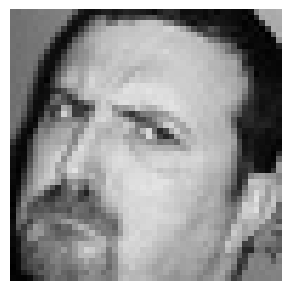

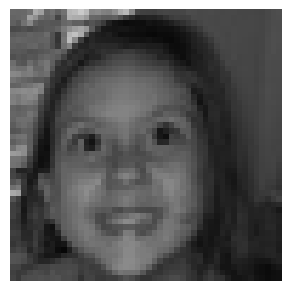

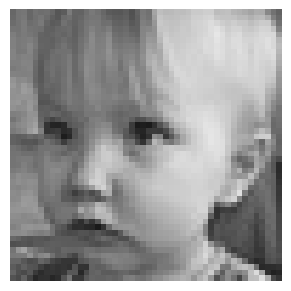

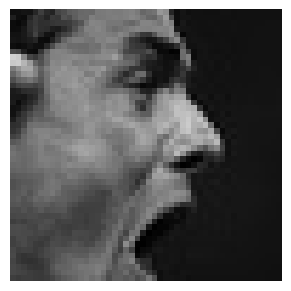

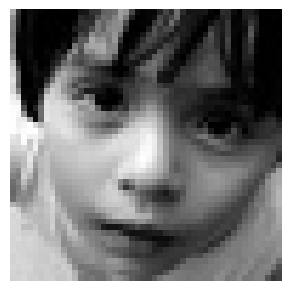

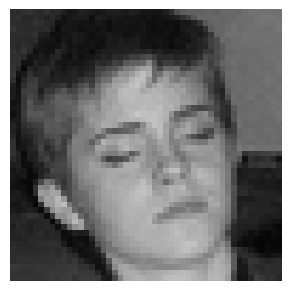

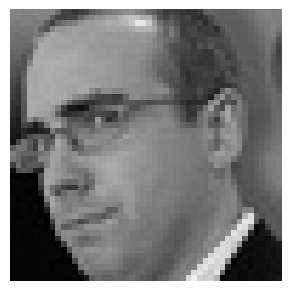

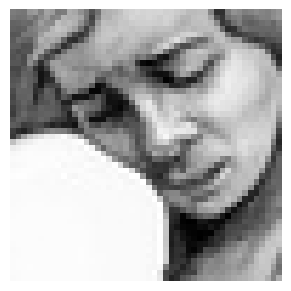

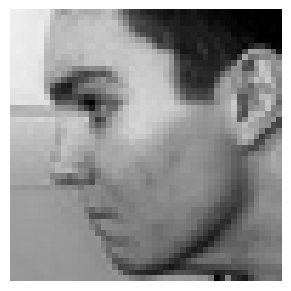

In [5]:
images = glob("train/**/**")
for i in range(9):
    image1 = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image1));plt.axis('off')

Customizing the dataset for training

In [6]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

validation_generator = datagen_validation.flow_from_directory("test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Creating/Preparing Functions For Model

In [7]:
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout,
    Dense, Input, GlobalAveragePooling2D, LeakyReLU
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, LeakyReLU, 
                                     MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D)

In [8]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same", kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

In [9]:
def model_fer(input_shape):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Convolution(inputs, 64, (3, 3))
    x = Convolution(x, 64, (3, 3))
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Block 2
    x = Convolution(x, 128, (3, 3))
    x = Convolution(x, 128, (3, 3))
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Block 3
    x = Convolution(x, 256, (3, 3))
    x = Convolution(x, 256, (3, 3))
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.35)(x)

    # Block 4
    x = Convolution(x, 512, (3, 3))
    x = Convolution(x, 512, (3, 3))
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Pooling + Dense
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)

    x = Dense(128, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)

    output = Dense(7, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer='adam',
        metrics=['accuracy']
    )

    return model
  


In [10]:
model = model_fer((48, 48, 1))
model.summary()

c:\Users\Viraj Sawant\OneDrive\Desktop\Visualize Activation Maps\Activation_Maps\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 4,858,567 (18.53 MB)

 Trainable params: 4,853,959 (18.52 MB)

 Non-trainable params: 4,608 (18.00 KB)

Training The Model

In [11]:
epochs = 50
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

In [12]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)


c:\Users\Viraj Sawant\OneDrive\Desktop\Visualize Activation Maps\Activation_Maps\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1977 - loss: 2.1335
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1343s 3s/step - accuracy: 0.1978 - loss: 2.1333 - val_accuracy: 0.2430 - val_loss: 1.8309
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 11:10 1s/step - accuracy: 0.3438 - loss: 1.8584

c:\Users\Viraj Sawant\OneDrive\Desktop\Visualize Activation Maps\Activation_Maps\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.3438 - loss: 1.8584 - val_accuracy: 0.2462 - val_loss: 1.8346
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2434 - loss: 1.8613
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 924s 2s/step - accuracy: 0.2434 - loss: 1.8613 - val_accuracy: 0.2511 - val_loss: 1.8537
Epoch 4/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13:37 2s/step - accuracy: 0.2500 - loss: 1.8795
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 79s 174ms/step - accuracy: 0.2500 - loss: 1.8795 - val_accuracy: 0.2446 - val_loss: 1.8649
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3043 - loss: 1.7720
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 981s 2s/step - accuracy: 0.3044 - loss: 1.7720 - val_accuracy: 0.3016 - val_loss: 1.8613
Epoch 6/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 14:52 2s/step - accuracy:

Plotting Graph 

Let's See The Loss Difference Between Trained And Predicted One

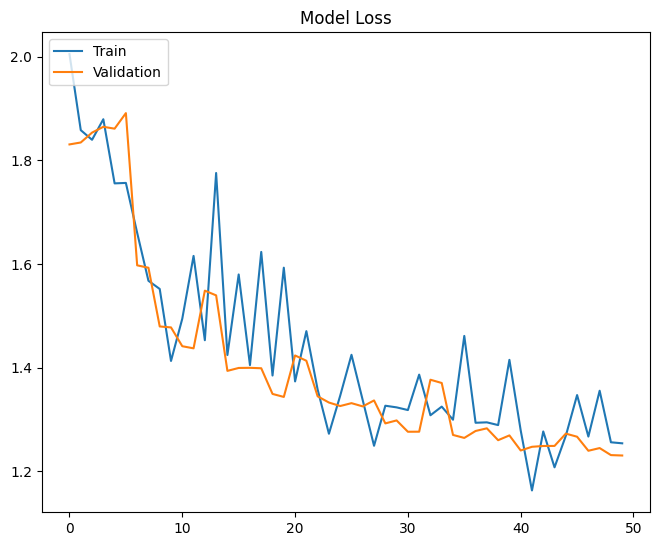

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

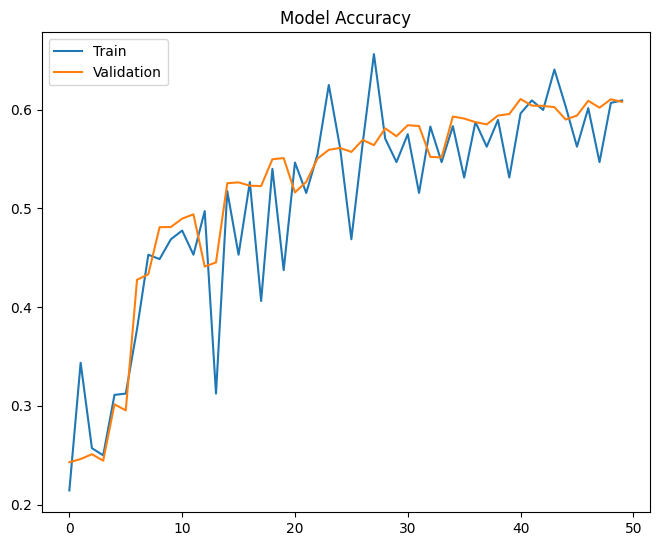

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

Evaluating The Accuracy And Loss

In [15]:
# Evaluate on validation or test set
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 418ms/step - accuracy: 0.6036 - loss: 1.2296
Validation Loss: 1.2296
Validation Accuracy: 61.27%


Visualizing All The Layers Present In The Model

Load and preprocess a grayscale face image

In [16]:
img_path = "child.jpg"  
img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

Build activation model

In [17]:

layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'Conv2D' in str(type(layer))]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


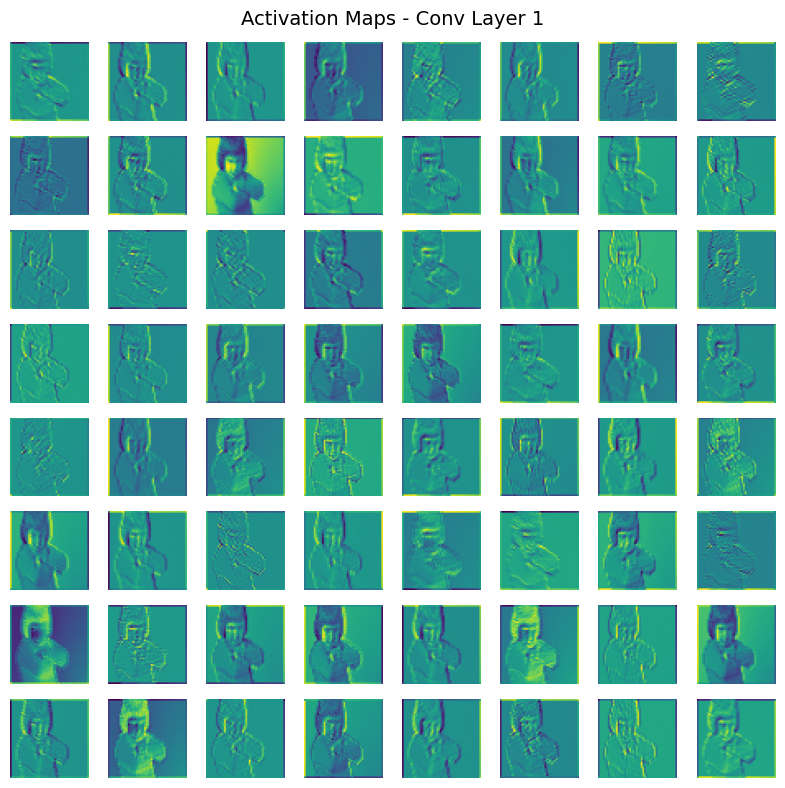

In [18]:


# Visualize activations
def plot_activation_maps(activation, layer_name, cols=8):
    activation = activation[0]
    num_features = activation.shape[-1]
    rows = num_features // cols
    plt.figure(figsize=(cols, rows))
    for i in range(num_features):
        plt.subplot(rows, cols, i+1)
        plt.imshow(activation[:, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Activation Maps - {layer_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

# show activation maps from first conv layer
plot_activation_maps(activations[0], "Conv Layer 1")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


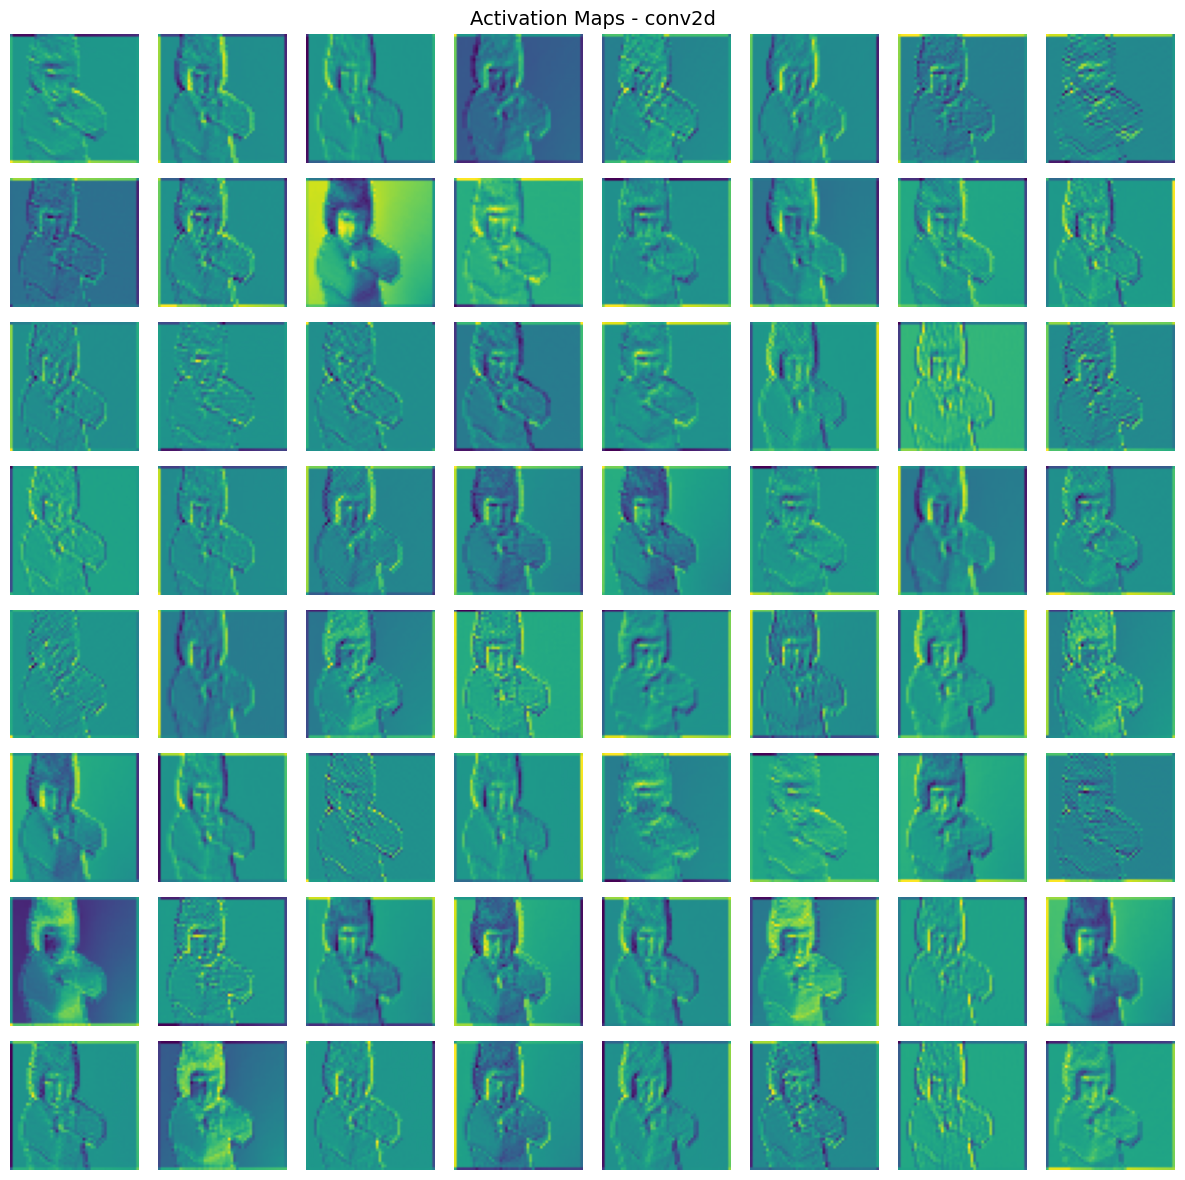

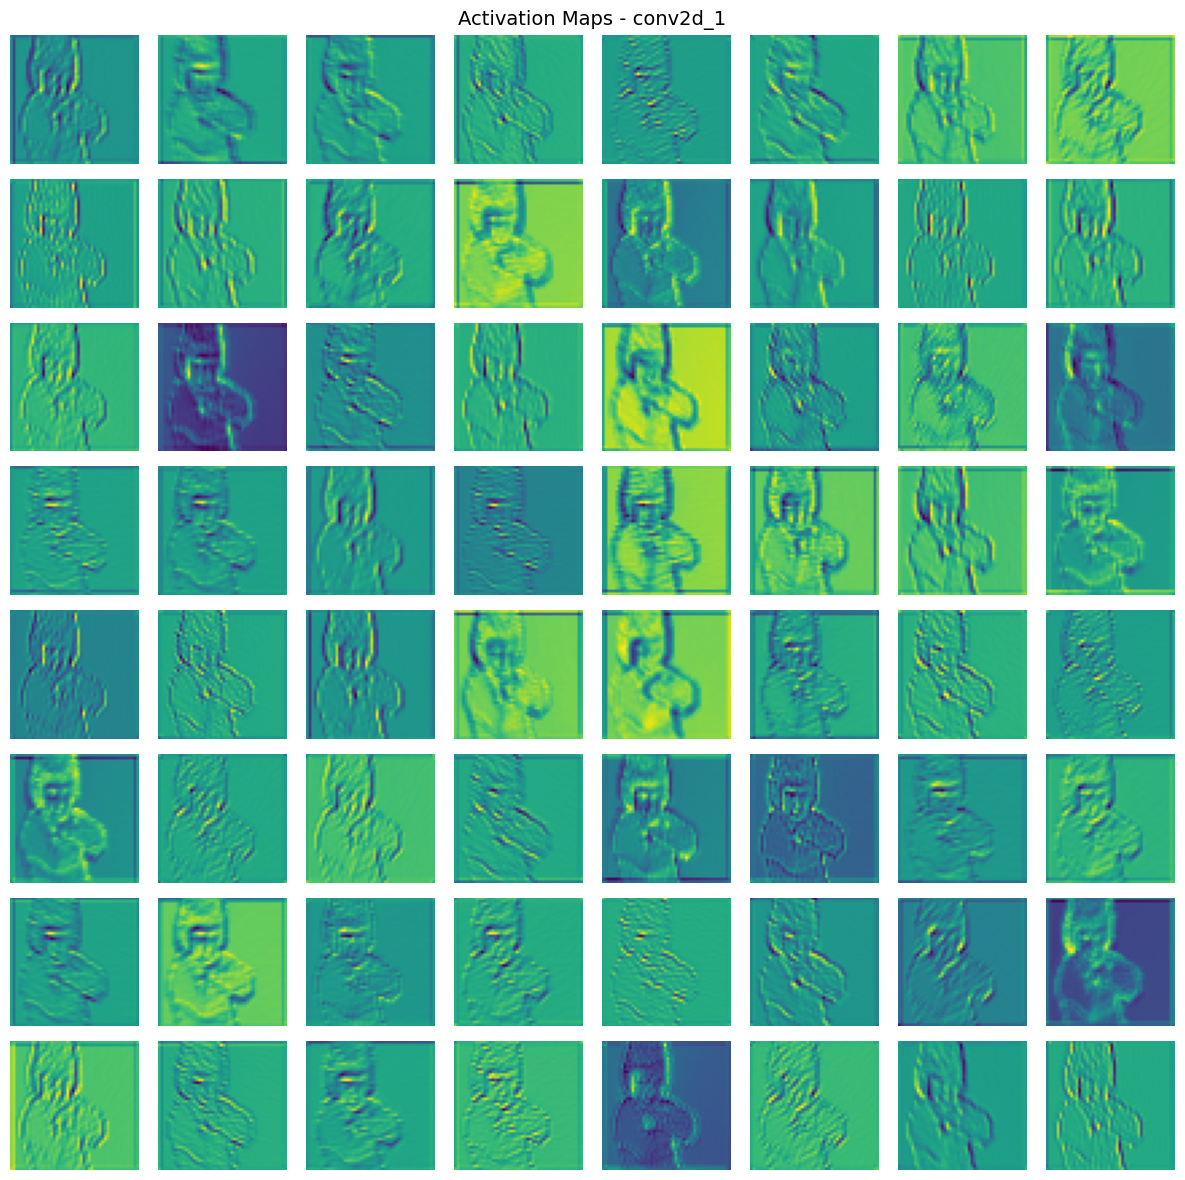

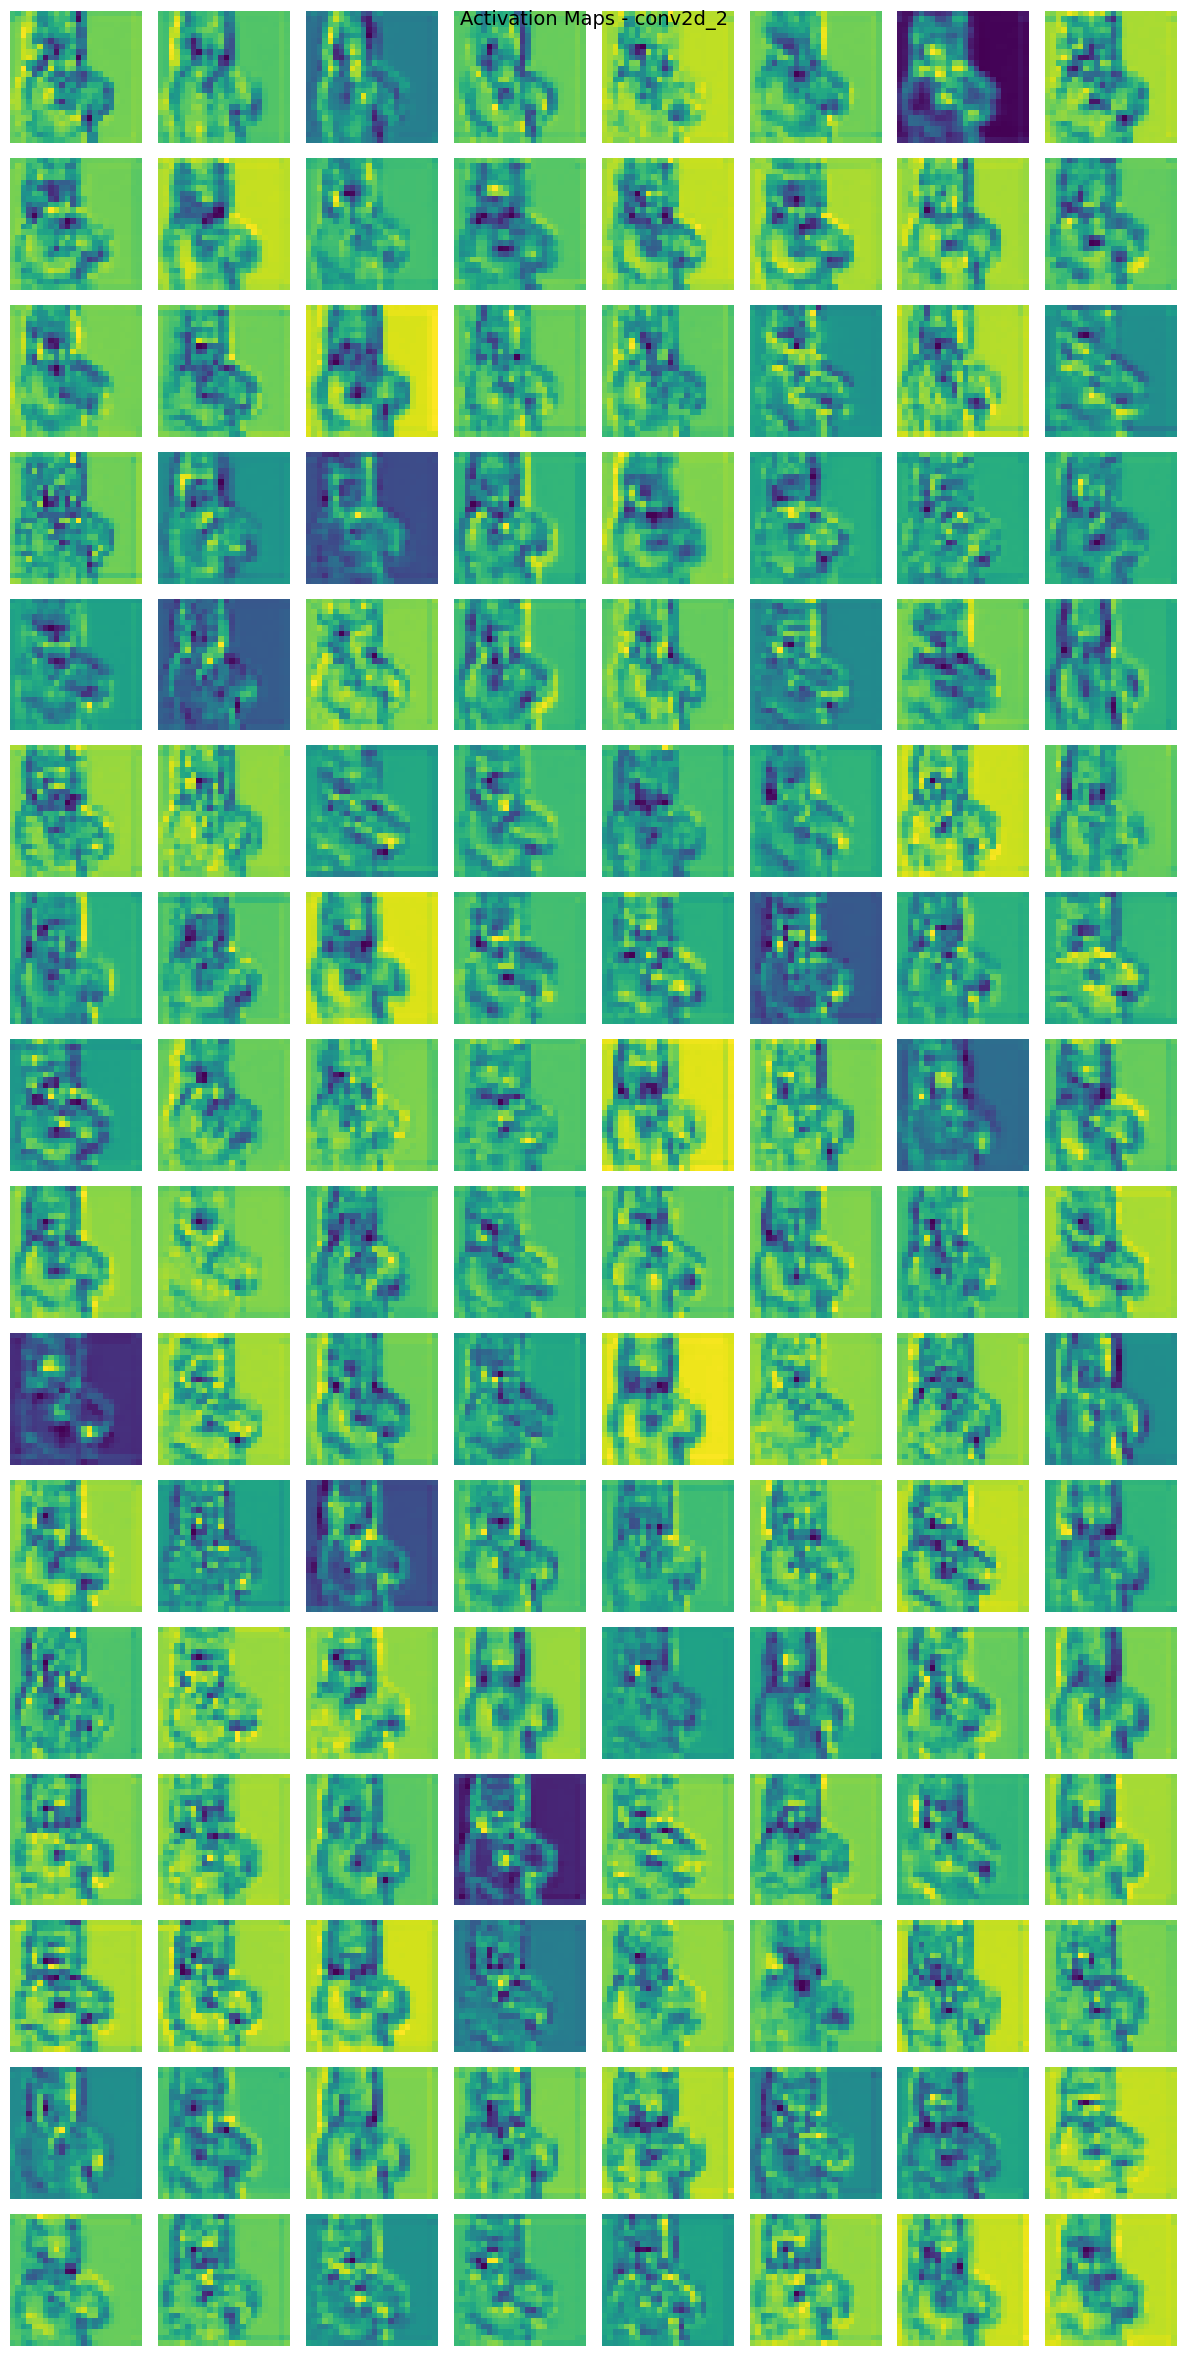

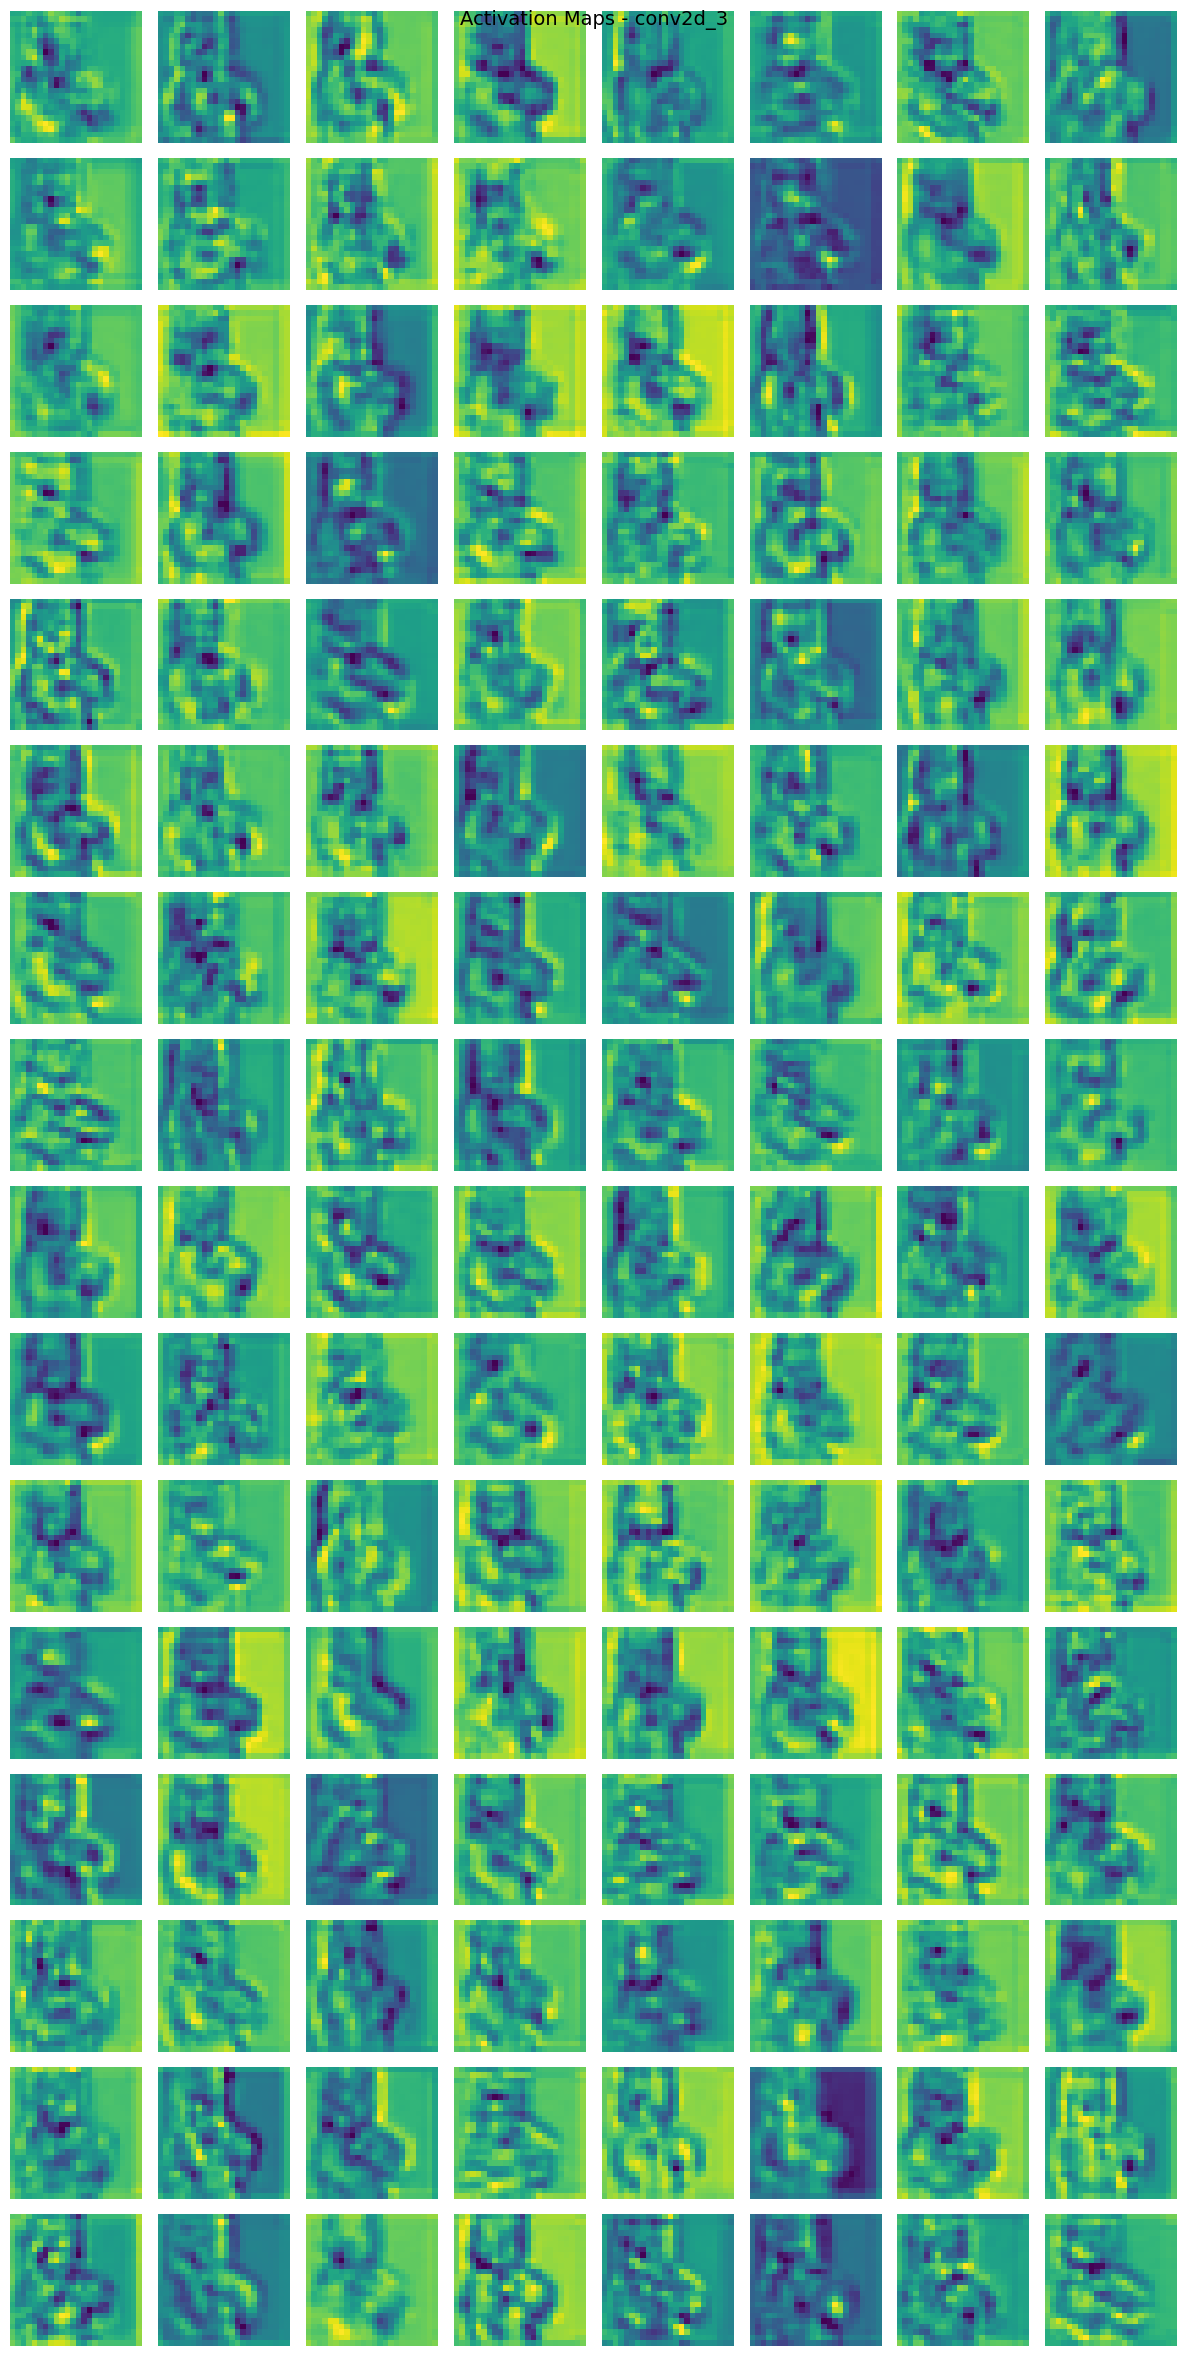

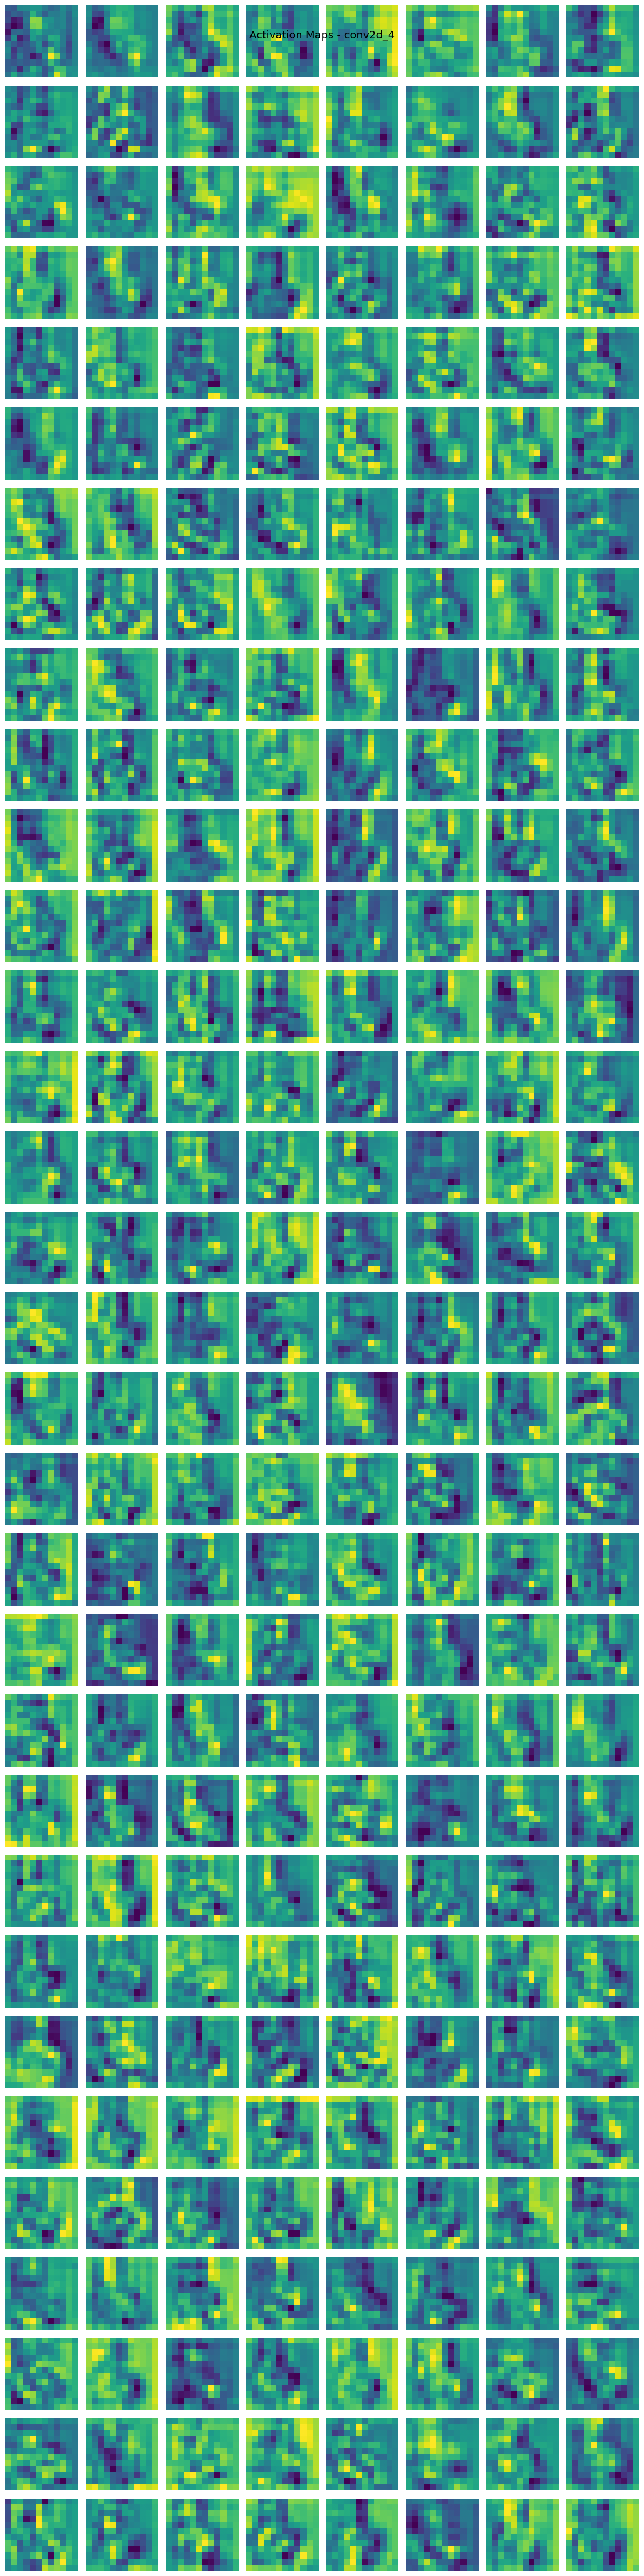

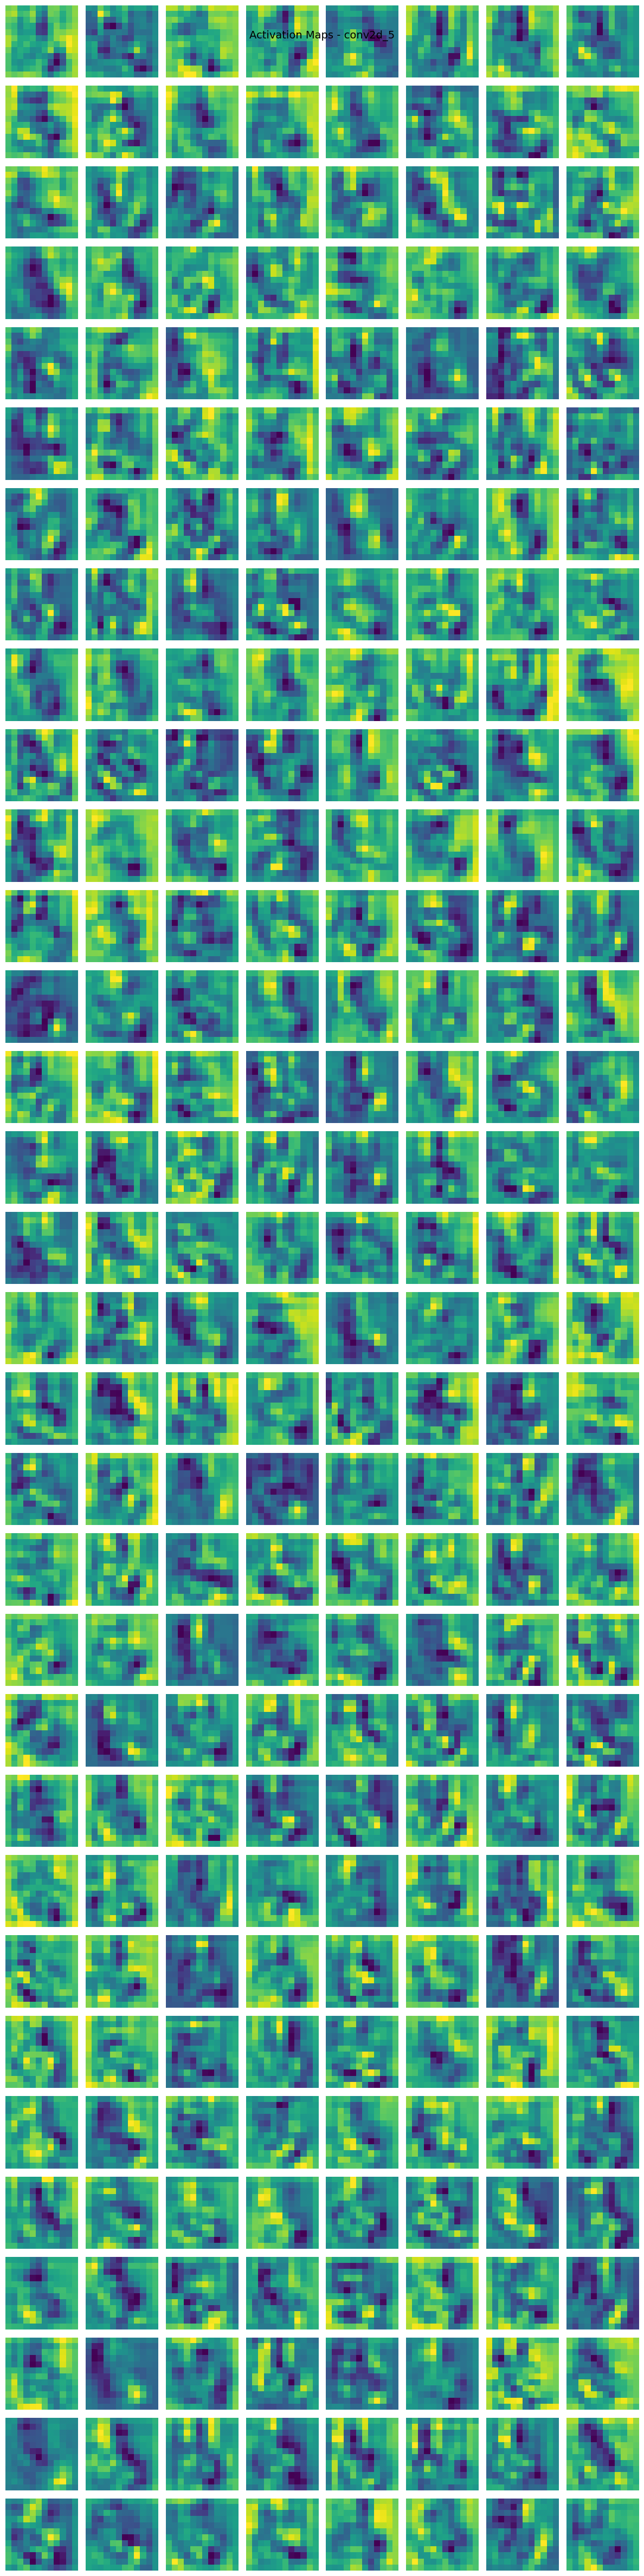

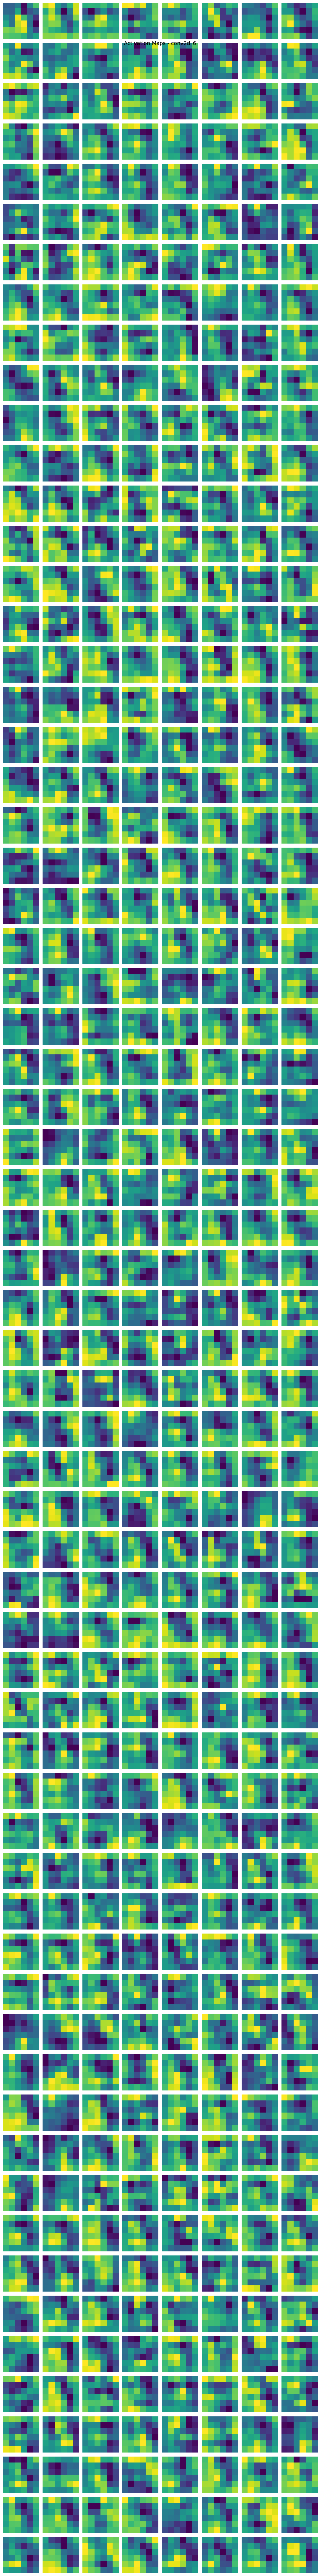

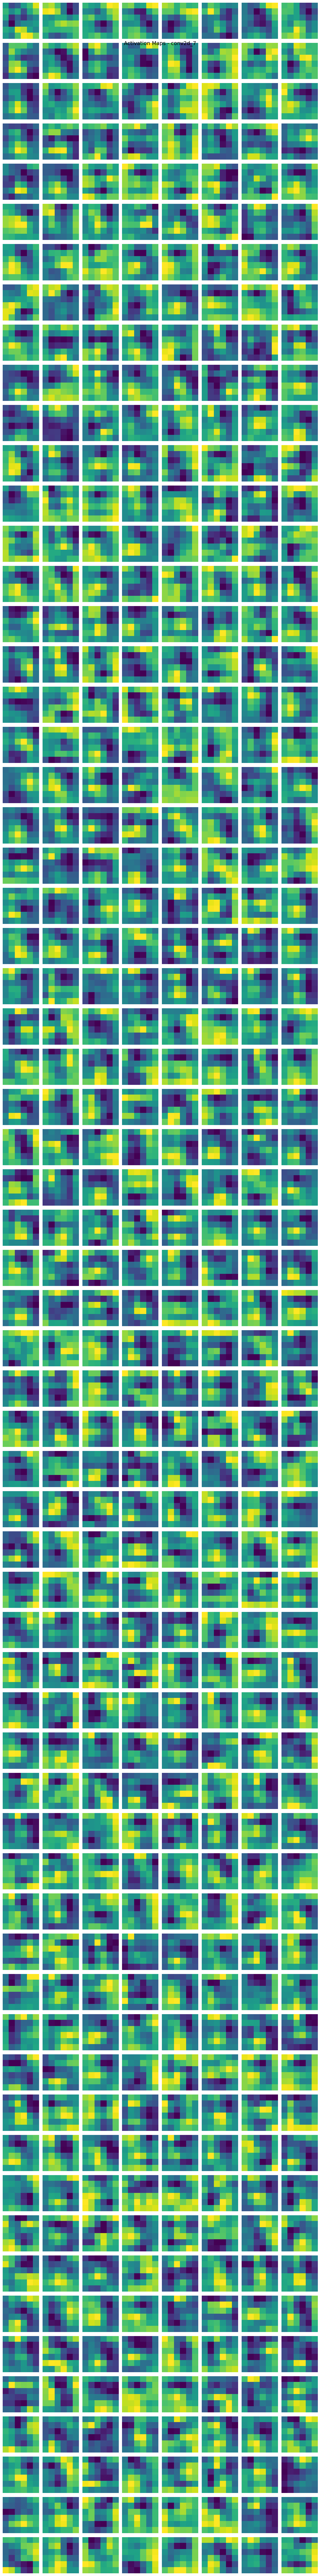

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Load and preprocess the grayscale image
img_path = "child.jpg"
img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Get convolutional layers only
conv_layers = [layer for layer in model.layers if 'conv' in layer.name.lower() or 'Conv2D' in str(type(layer))]
layer_outputs = [layer.output for layer in conv_layers]

# Build a model that returns all conv layer activations
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Predict to get activations
activations = activation_model.predict(img_array)

# Function to plot activation maps
def plot_activation_maps(activation, layer_name, cols=8):
    activation = activation[0]  # Remove batch dimension
    num_features = activation.shape[-1]
    rows = (num_features + cols - 1) // cols
    plt.figure(figsize=(cols * 1.5, rows * 1.5))
    for i in range(num_features):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(activation[:, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Activation Maps - {layer_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Loop over all conv layers and plot their activations
for i, activation in enumerate(activations):
    layer_name = conv_layers[i].name
    plot_activation_maps(activation, layer_name)


In [20]:
import os
import matplotlib.pyplot as plt

# Create the desired folder
save_dir = "Layer Images"
os.makedirs(save_dir, exist_ok=True)

# Function to plot and save activation maps
def plot_and_save_activation_maps(activation, layer_name, cols=8):
    activation = activation[0]  # Remove batch dimension
    num_features = activation.shape[-1]
    rows = (num_features + cols - 1) // cols

    plt.figure(figsize=(cols * 1.5, rows * 1.5))
    for i in range(num_features):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(activation[:, :, i], cmap='viridis')
        plt.axis('off')

    plt.suptitle(f'Activation Maps - {layer_name}', fontsize=14)
    plt.tight_layout()
    
    # Save the plot to the folder
    file_path = os.path.join(save_dir, f"{layer_name}.png")
    plt.savefig(file_path)
    plt.close()

# Loop through and save all conv layer activations
for i, activation in enumerate(activations):
    layer_name = conv_layers[i].name
    plot_and_save_activation_maps(activation, layer_name)

print("Activation maps saved in folder:", save_dir)


Activation maps saved in folder: Layer Images


Saving The Model

In [21]:
model_json = model.to_json()

with open("saved_model.json", "w") as json_file:
    json_file.write(model_json)

print("saved_model.json")


saved_model.json


In [22]:
model.save_weights("emotion_model.weights.h5")
